<a href="https://colab.research.google.com/github/RSNA/MagiciansCorner/blob/master/MC8_HowToConnectToPACS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Magicians Corner 8 - How to connect an algorithm to a PACS

###by: Bradley J Erickson, MD PhD and Felipe Kitamura, MD MSc
*Copyright 2020

###See corresponding Radiology: AI article here:

In this tutorial we will:



1.   Connect to a (cloud) PACS
2.   Test if the connection is established
3.   Query the PACS for a specific study
4.   Retrieve this study
5.   Perform an inference on this study (lung segmentation).
6.   Send the result back to the PACS

We will use an open PACS used for testing (https://www.dicomserver.co.uk/).


Acknowledgements to:
- pydicom and pynetdicom developers in keeping a complete documentation.
- Johannes Hofmanninger (https://github.com/JoHof/lungmask#COVID-19-Web)


In [ ]:
# Cell 1
# First we will install the libraries we will use. It should take a few seconds.

!pip install git+https://github.com/JoHof/lungmask

!pip install pynetdicom #this is the DICOM DIMSE protocol library for Python

print('\x1b[1;31m'+'Go to the next cell.'+'\x1b[0m')

  Cloning https://github.com/JoHof/lungmask to /tmp/pip-req-build-vfqq7_qz
  Running command git clone -q https://github.com/JoHof/lungmask /tmp/pip-req-build-vfqq7_qz
     |████████████████████████████████| 35.5MB 89kB/s 
     |████████████████████████████████| 42.5MB 58kB/s 
     |████████████████████████████████| 1.0MB 37.1MB/s 
     |████████████████████████████████| 3.0MB 40.5MB/s 
  Created wheel for lungmask: filename=lungmask-0.2.8-cp36-none-any.whl size=25341 sha256=4716a116e095ddf23236236b3bec899ed70edf9f11775a8dcf33de3858e8831c
  Stored in directory: /tmp/pip-ephem-wheel-cache-j11n6daw/wheels/59/2e/c0/1365551c1853d11aef03baf7ed94cdac831342c7f8a03e45ca
Successfully built lungmask
     |████████████████████████████████| 1.6MB 3.2MB/s 
Go to the next cell.


In [ ]:
# Cell 2
# Then we import some useful libraries, including the last one we installed

from pynetdicom import (
    AE, evt, build_role,
    StoragePresentationContexts,
    PYNETDICOM_IMPLEMENTATION_UID,
    PYNETDICOM_IMPLEMENTATION_VERSION
)
from pynetdicom.sop_class import (
    StudyRootQueryRetrieveInformationModelFind,
    PatientRootQueryRetrieveInformationModelGet,
    StudyRootQueryRetrieveInformationModelGet,
    StudyRootQueryRetrieveInformationModelMove,
    CTImageStorage

)

import pydicom
from pydicom import dcmread
from pydicom.dataset import Dataset
import os
from matplotlib import pyplot as plt
from glob import glob


import numpy as np
import numpy.ma as ma
import shutil
import imageio
import cv2
from natsort import natsorted
import random
import datetime, time


from lungmask import mask # This is the Deep Learning model we will use to segment the lungs
import SimpleITK as sitk

import warnings
warnings.filterwarnings("ignore")

print('\x1b[1;31m'+'Go to the next cell.'+'\x1b[0m')

Go to the next cell.


In [ ]:
# Cell 3
# We must set up the information about PACS we will connect to
# when you want to connect to your local PACS, change this address and port

PACS_addr = "www.dicomserver.co.uk"
port = 104

print('\x1b[1;31m'+'Go to the next cell.'+'\x1b[0m')

Go to the next cell.


In [ ]:
# Cell 4
# Now we connect to the PACS and send a C-ECHO to test if we were able to establish connection

ae = AE(ae_title=b'ANY-SCU')
# Verification SOP Class has a UID of 1.2.840.10008.1.1
#   we can use the UID str directly when adding the requested
#   presentation context
ae.add_requested_context('1.2.840.10008.1.1')
ae.add_requested_context(StudyRootQueryRetrieveInformationModelFind)

# Associate with a peer AE
assoc = ae.associate(PACS_addr, port)

if assoc.is_established:
    print("Association established.")
    # Send a DIMSE C-ECHO request to the peer
    status = assoc.send_c_echo()

    # Print the response from the peer
    if status:
        print('C-ECHO Response: 0x{0:04x}'.format(status.Status))

    # Release the association
    assoc.release()
    print("Association Released.")
else:
    print("Association not established.")
    
print('\x1b[1;31m'+'Go to the next cell.'+'\x1b[0m')

INFO:pynetdicom.assoc:Requesting Association
INFO:pynetdicom.acse:Association Accepted
Association established.
INFO:pynetdicom.assoc:Sending Echo Request: MsgID 1
INFO:pynetdicom.events:Received Echo Response (Status: Success)
C-ECHO Response: 0x0000
INFO:pynetdicom.assoc:Releasing Association
Association Released.
Go to the next cell.


A C-ECHO Response of 0x0000 means we were able to communicate with the PACS

In [ ]:
# Cell 5
# Then we define the filters to query the specific study of interest

ds = pydicom.Dataset()
#ds.PatientName = ''
#ds.Modality = 'CT'
ds.StudyDescription = '*'
ds.QueryRetrieveLevel = 'STUDY'
ds.AccessionNumber = '1400059968'
ds.PatientID = '*'
ds.StudyInstanceUID = '*'
# print the group and elements just to see what is there
print(ds)

print('\x1b[1;31m'+'Go to the next cell.'+'\x1b[0m')

(0008, 0050) Accession Number                    SH: '1400059968'
(0008, 0052) Query/Retrieve Level                CS: 'STUDY'
(0008, 1030) Study Description                   LO: '*'
(0010, 0020) Patient ID                          LO: '*'
(0020, 000d) Study Instance UID                  UI: *
Go to the next cell.


We will filter by AccessionNumber, a DICOM tag that should be unique for each study.
The other tags with value '*' tell the PACS we want those information back.

In [ ]:
# Cell 6

# Here we establish a connection again, but now we will send a C-FIND to query the PACS using the filter we defined before.

ae = AE(ae_title=b'ANY-SCU')
# Verification SOP Class has a UID of 1.2.840.10008.1.1
#   we can use the UID str directly when adding the requested
#   presentation context
ae.add_requested_context('1.2.840.10008.1.1')
ae.add_requested_context(StudyRootQueryRetrieveInformationModelFind)

# Associate with a peer AE
assoc = ae.associate(PACS_addr, port)

if assoc.is_established:
    # Send a DIMSE C-ECHO request to the peer
    status = assoc.send_c_echo()

    # Print the response from the peer
    if status:
        print('C-ECHO Response: 0x{0:04x}'.format(status.Status))
        responses = assoc.send_c_find(ds,StudyRootQueryRetrieveInformationModelFind)
        for (status, identifier) in responses:
            if status:
                print('C-FIND query status: 0x{0:04x}'.format(status.Status))

                # If the status is 'Pending' then identifier is the C-FIND response
                if status.Status in (0xFF00, 0xFF01):
                    print(identifier)
                    StudyFound = identifier
            else:
                print('Connection timed out, was aborted or received invalid response')
    # Release the association
    assoc.release()
    print("Association Released.")
    
print('\x1b[1;31m'+'Go to the next cell.'+'\x1b[0m')

INFO:pynetdicom.assoc:Requesting Association
INFO:pynetdicom.acse:Association Accepted
INFO:pynetdicom.assoc:Sending Echo Request: MsgID 1
INFO:pynetdicom.events:Received Echo Response (Status: Success)
C-ECHO Response: 0x0000
INFO:pynetdicom.assoc:Sending Find Request: MsgID 1
INFO:pynetdicom.assoc:
INFO:pynetdicom.assoc:# Request Identifier
INFO:pynetdicom.assoc:(0008,0050) SH [1400059968]                             # 1 AccessionNumber
INFO:pynetdicom.assoc:(0008,0052) CS [STUDY]                                  # 1 QueryRetrieveLevel
INFO:pynetdicom.assoc:(0008,1030) LO [*]                                      # 1 StudyDescription
INFO:pynetdicom.assoc:(0010,0020) LO [*]                                      # 1 PatientID
INFO:pynetdicom.assoc:(0020,000D) UI [*]                                      # 1 StudyInstanceUID
INFO:pynetdicom.assoc:
INFO:pynetdicom.assoc:Find SCP Response: 1 - 0xFF00 (Pending)
INFO:pynetdicom.assoc:
INFO:pynetdicom.assoc:# Response Identifier
INFO:pynetdico

The output above shows the information of the study we found in the PACS. We will use the StudyInstanceUID as the identifier to download this study from the PACS to this Colab Notebook.

In [ ]:
# Cell 7
# Having found a study of interest, we will send a C-GET to download it

path = 'study/' # Folder to save the incoming DICOM files
os.makedirs(path, exist_ok=True)

# Implement the handler for evt.EVT_C_STORE
def handle_store(event):
    """Handle a C-STORE request event."""
    ds = event.dataset
    context = event.context

    # Add the DICOM File Meta Information
    meta = pydicom.Dataset()
    meta.MediaStorageSOPClassUID = ds.SOPClassUID
    meta.MediaStorageSOPInstanceUID = ds.SOPInstanceUID
    meta.ImplementationClassUID = PYNETDICOM_IMPLEMENTATION_UID
    meta.ImplementationVersionName = PYNETDICOM_IMPLEMENTATION_VERSION
    meta.TransferSyntaxUID = context.transfer_syntax

    # Add the file meta to the dataset
    ds.file_meta = meta

    # Set the transfer syntax attributes of the dataset
    ds.is_little_endian = context.transfer_syntax.is_little_endian
    ds.is_implicit_VR = context.transfer_syntax.is_implicit_VR

    print("Saving file: " + ds.SOPInstanceUID + ".dcm")
    # Save the dataset using the SOP Instance UID as the filename    
    ds.save_as(path + ds.SOPInstanceUID + ".dcm", write_like_original=False)

    # Return a 'Success' status
    return 0x0000

handlers = [(evt.EVT_C_STORE, handle_store)]

# Initialise the Application Entity
ae = AE()

# Add the requested presentation contexts (QR SCU)
ae.add_requested_context(StudyRootQueryRetrieveInformationModelGet)
# Add the requested presentation context (Storage SCP)
ae.add_requested_context(CTImageStorage)

# Create an SCP/SCU Role Selection Negotiation item for CT Image Storage
role = build_role(CTImageStorage, scp_role=True)

# Create our Identifier (query) dataset
# We need to supply a Unique Key Attribute for each level above the
#   Query/Retrieve level
ds = pydicom.Dataset()
ds.QueryRetrieveLevel = 'STUDY'
ds.StudyInstanceUID = StudyFound.StudyInstanceUID # Use the StudyInstanceUID from the study we found before


# Associate with peer AE at PACS_addr and port defined in the beginning 
assoc = ae.associate(PACS_addr, port, ext_neg=[role], evt_handlers=handlers)

if assoc.is_established:
    # Use the C-GET service to send the identifier
    responses = assoc.send_c_get(ds, StudyRootQueryRetrieveInformationModelGet)

    for (status, identifier) in responses:
        if status:
            print('C-GET query status: 0x{0:04x}'.format(status.Status))
        else:
            print('Connection timed out, was aborted or received invalid response')

    # Release the association
    assoc.release()
else:
    print('Association rejected, aborted or never connected')
    
print('\x1b[1;31m'+'Go to the next cell.'+'\x1b[0m')

INFO:pynetdicom.assoc:Requesting Association
INFO:pynetdicom.acse:Association Accepted
INFO:pynetdicom.assoc:Sending Get Request: MsgID 1
INFO:pynetdicom.assoc:
INFO:pynetdicom.assoc:# Request Identifier
INFO:pynetdicom.assoc:(0008,0052) CS [STUDY]                                  # 1 QueryRetrieveLevel
INFO:pynetdicom.assoc:(0020,000D) UI [1.2.826.0.1.3680043.10.474.1443803479411049912639801153165837370] # 1 StudyInstanceUID
INFO:pynetdicom.assoc:
INFO:pynetdicom.events:Received Store Request
Saving file: 1.2.826.0.1.3680043.10.474.1785589744287203856749847567861731014.dcm
INFO:pynetdicom.assoc:Get SCP Response: 1 - 0xFF00 (Pending)
INFO:pynetdicom.assoc:Sub-Operations Remaining: 92, Completed: 1, Failed: 0, Warning: 0
C-GET query status: 0xff00
INFO:pynetdicom.events:Received Store Request
Saving file: 1.2.826.0.1.3680043.10.474.1007151019669848708841711441708469624.dcm
INFO:pynetdicom.assoc:Get SCP Response: 2 - 0xFF00 (Pending)
INFO:pynetdicom.assoc:Sub-Operations Remaining: 91, Co

A C-GET query status of 0xff00 means there are pending operations (files to be transfered). A C-GET status of 0x0000 means operation finished.

In [ ]:
# Cell 8

# We can list the files in the study/ folder to see if the DICOM files were downloaded properly.

#!rm -rf study/
!ls study/
!ls study/ | wc

print('\x1b[1;31m'+'Go to the next cell.'+'\x1b[0m')

1.2.826.0.1.3680043.10.474.1007151019669848708841711441708469624.dcm
1.2.826.0.1.3680043.10.474.1096912837458569402222908109502895956.dcm
1.2.826.0.1.3680043.10.474.1150047646137855299500833784356548949.dcm
1.2.826.0.1.3680043.10.474.1209227480144022513588276293443615674.dcm
1.2.826.0.1.3680043.10.474.1223116895581768813136653932343017567.dcm
1.2.826.0.1.3680043.10.474.1322687231741815650309858587496862844.dcm
1.2.826.0.1.3680043.10.474.1327569359818407486331208579145300365.dcm
1.2.826.0.1.3680043.10.474.1339731493152735907229495358049770917.dcm
1.2.826.0.1.3680043.10.474.1367782641190487799770876677322674914.dcm
1.2.826.0.1.3680043.10.474.1375276616361853524410959535709123832.dcm
1.2.826.0.1.3680043.10.474.1391545181159220067865362603228553580.dcm
1.2.826.0.1.3680043.10.474.1410936061906793298189178354710857805.dcm
1.2.826.0.1.3680043.10.474.1424878490500719785999598764835069692.dcm
1.2.826.0.1.3680043.10.474.1499166517030593596367144761771966853.dcm
1.2.826.0.1.3680043.10.474.1550719

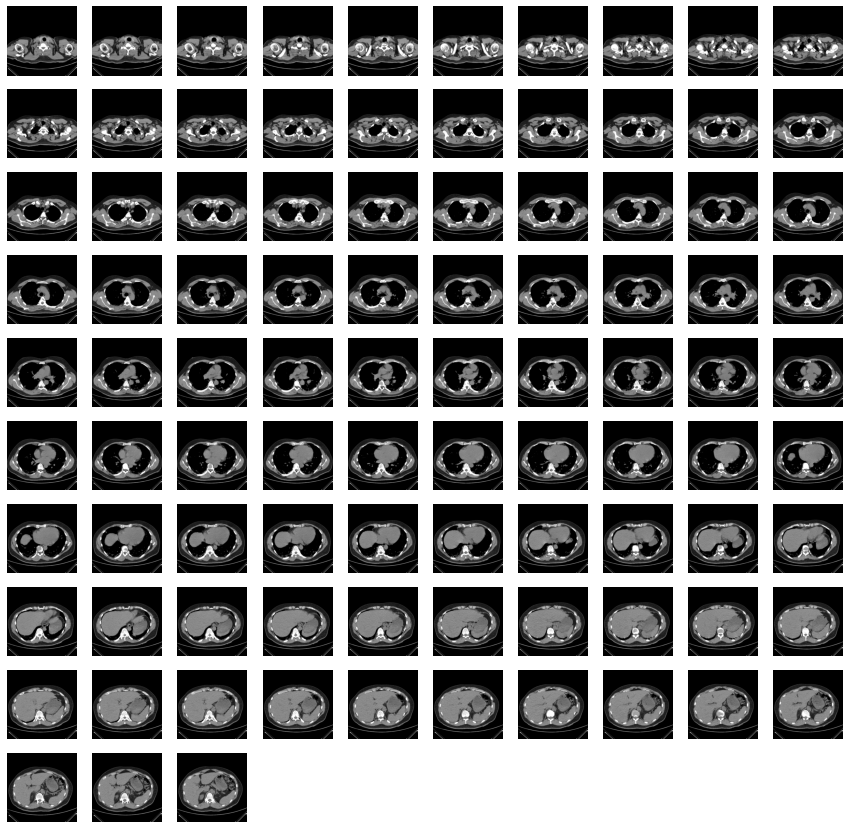

Go to the next cell.


In [ ]:
# Cell 9

# Let's take a look at the files we've just retrieved from the PACS

# This is an anonymized study that we will use as example.

# When plotting the images, we will also save them as JPG files to use the open-source lung segmentation model.

WW = 400 # Window Width in Hounsfield Units
WC = 40 # Window Center in Hounsfield Units
LW = WC - WW/2
UW = WC + WW/2

files = glob("study/*.dcm") # List all DICOM files

DS = [pydicom.dcmread(_f) for _f in files] # Load them

DS = sorted(DS, key= lambda x: float(x.SliceLocation)) # Orderm them by Slice Location

plt.figure(figsize=(15,15)) # Create a plot

for i, _ds in enumerate(DS): #For each DICOM
    
    img = _ds.pixel_array # Load the image 
    img = img * _ds.RescaleSlope + _ds.RescaleIntercept # Rescale values to Hounsfield Units
    img[img < LW] = LW # Apply Lower Window Attenuation
    img[img > UW] = UW # Apply Upper Window Attenuation
    plt.subplot(10, 10, i+1)
    plt.imshow(img, cmap = "gray") # Plot image as grayscale
    plt.axis('off')


plt.show()

print('\x1b[1;31m'+'Go to the next cell.'+'\x1b[0m')


Downloading: "https://github.com/JoHof/lungmask/releases/download/v0.0/unet_r231-d5d2fc3d.pth" to /root/.cache/torch/checkpoints/unet_r231-d5d2fc3d.pth


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  5.97it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  5.06it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  5.92it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  5.94it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  6.03it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  6.01it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  6.07it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  6.01it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  6.04it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  5.77it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  5.98it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  6.10it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  6.06it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  6.19it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:

Total execution time was 84.8358268737793 seconds.


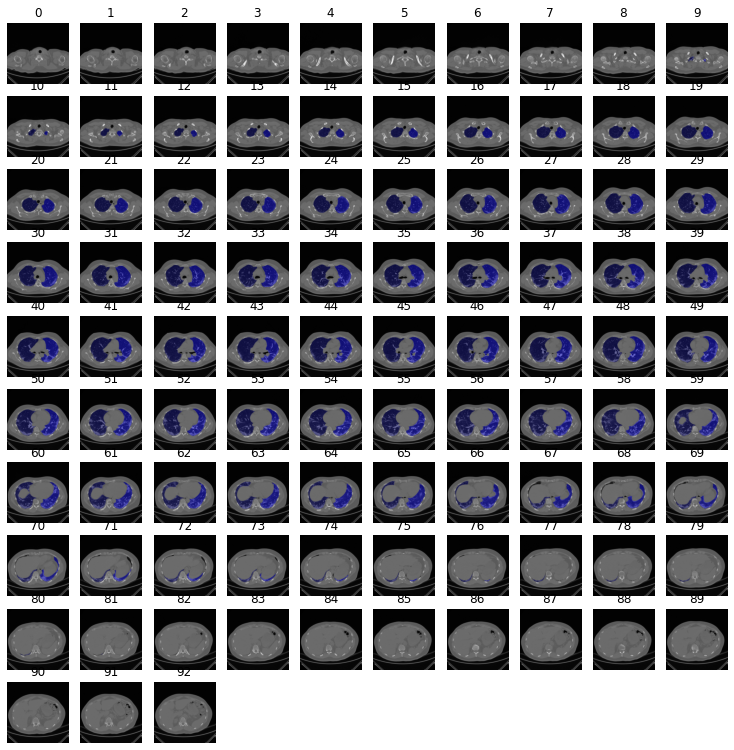

Go to the next cell.


In [ ]:
# Cell 10

# Next step, we will create our AI tool. Since this AI is not the focus, we will
# load the trained u-net from a prior article and will simply do the inference,
# and no training. This should take no more than 2 minutes.

files = glob("study/*.dcm") # List all DICOM files

os.makedirs("testimages_pred", exist_ok=True)


starting_time = time.time()

for j in range(0, len(files)):
    i = j 
    image = np.zeros((512,512,3))
    pred = np.zeros((512,512,3))
    ds = pydicom.dcmread(files[i])

    image[...,0] = ds.pixel_array / (2 ** 11)
    image[...,1] = ds.pixel_array / (2 ** 11)
    image[...,2] = ds.pixel_array / (2 ** 11)

    input_image = sitk.ReadImage(files[i])
    pred[...,2] = mask.apply(input_image)
    pred[...,2] = ma.masked_where(pred[...,2] == 0, pred[...,2])

    InstanceNumber = ds.InstanceNumber

    
    img = cv2.addWeighted(image, 0.8, pred, 0.2, 0)
    
    cv2.imwrite("testimages_pred/" + str(InstanceNumber).zfill(4) + ".jpg", np.moveaxis(np.asarray([img[...,2], img[...,1], img[...,0]]),0,-1)*255,)

print ("Total execution time was " + str(time.time() - starting_time) + " seconds.")

im_list = natsorted(os.listdir('./testimages_pred'))

fig=plt.figure(figsize=(250, 50))

for i, f in enumerate(im_list):
    pth = './testimages_pred/' + f 
    img = imageio.imread(pth)
    fig.add_subplot(10, 10, i+1)
    plt.imshow(img)
    plt.title(i)
    plt.axis('off')

plt.subplots_adjust(bottom=0.1, left = 0.01, right=0.05, top=0.3)
plt.show()

print('\x1b[1;31m'+'Go to the next cell.'+'\x1b[0m')

In [ ]:
# Cell 11

# To send the results back to PACS we need to create new DICOM files

# Look for the line: ds.PatientName = "Putyournamehere" and change it so you can
# check the result later

os.makedirs('dcm_pred', exist_ok=True)

dt = datetime.datetime.now()

series_unique = dt.strftime('%Y%m%d') + dt.strftime('%H%M%S.%f')
series_unique = series_unique.replace(".0", ".1")

PID = str(np.random.randint(0,1000000))
print ("Patient ID generated is " + str(PID))

im_list = natsorted(os.listdir('./testimages_pred'))

for i, f in enumerate(im_list):
    pth = './testimages_pred/' + f 
    img = imageio.imread(pth)
    ds = pydicom.Dataset()
    # Create some temporary filenames
    suffix = '.dcm'
    filename_little_endian = f.replace(".jpg", "")

    dt = datetime.datetime.now()

    sop_unique = dt.strftime('%Y%m%d') + dt.strftime('%H%M%S.%f')
    sop_unique = sop_unique.replace(".0", ".1")

    print("Setting file meta information...")
    # Populate required values for file meta information
    file_meta = Dataset()
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.7'
    file_meta.MediaStorageSOPInstanceUID = "1.2.3.1" + sop_unique
    file_meta.ImplementationClassUID = "1.2.3.4"
    file_meta.TransferSyntaxUID = '1.2.840.10008.1.2'

    print("Setting dataset values...")
    # Create the FileDataset instance (initially no data elements, but file_meta
    # supplied)
    ds = pydicom.FileDataset(filename_little_endian, {},
                    file_meta=file_meta, preamble=b"\0" * 128)

    # Add the data elements -- not trying to set all required here. Check DICOM
    # standard

    
    ###########################################################################
    ###########################################################################
    
    # Change this string to check your result in the end of this notebook

    ds.PatientName = "Putyournamehere" 

    ###########################################################################
    ###########################################################################


    ds.PatientID = PID
    ds.AccessionNumber = PID + "002"
    ds.PatientBirthDate = ""
    ds.PatientSex = ""
    ds.ReferringPhysicianName = ""
    ds.StudyDescription = "Lung Segmentation Inference Study"
    ds.SeriesDescription = "Lung Segmentation Inference Series"
    

    # Set the transfer syntax
    ds.is_little_endian = True
    ds.is_implicit_VR = True

    ds.StudyInstanceUID = "1.2.3.1" + series_unique + ".1"
    ds.SeriesInstanceUID = "1.2.3.1" + series_unique + ".2"
    ds.SOPInstanceUID = ds.file_meta.MediaStorageSOPInstanceUID
    ds.SOPClassUID = ds.file_meta.MediaStorageSOPClassUID

    # Set creation date/time
    
    ds.ContentDate = dt.strftime('%Y%m%d')
    timeStr = dt.strftime('%H%M%S.%f')  # long format with micro seconds
    ds.ContentTime = timeStr

    ds.StudyDate = ds.ContentDate
    ds.StudyTime = ds.ContentTime

    ds.InstanceNumber = i

    ds.StudyID = PID + "001"

    ds.Rows = img.shape[0]
    ds.Columns = img.shape[1]
    ds.SamplesPerPixel = 3
    ds.PhotometricInterpretation = 'RGB'
    ds.BitsStored = 8
    ds.HighBit = 7
    ds.BitsAllocated = 8
    ds.Modality = 'CT'
    ds.SeriesNumber = '201'

    ds.PixelData = img.tobytes()

    print("Writing test file", filename_little_endian)
    ds.save_as('dcm_pred/' + f.replace("jpg", "dcm"))
    print("File saved.")

print('\x1b[1;31m'+'Go to the next cell.'+'\x1b[0m')

Patient ID generated is 718413
Setting file meta information...
Setting dataset values...
Writing test file 0015
File saved.
Setting file meta information...
Setting dataset values...
Writing test file 0016
File saved.
Setting file meta information...
Setting dataset values...
Writing test file 0017
File saved.
Setting file meta information...
Setting dataset values...
Writing test file 0018
File saved.
Setting file meta information...
Setting dataset values...
Writing test file 0019
File saved.
Setting file meta information...
Setting dataset values...
Writing test file 0020
File saved.
Setting file meta information...
Setting dataset values...
Writing test file 0021
File saved.
Setting file meta information...
Setting dataset values...
Writing test file 0022
File saved.
Setting file meta information...
Setting dataset values...
Writing test file 0023
File saved.
Setting file meta information...
Setting dataset values...
Writing test file 0024
File saved.
Setting file meta information

In [ ]:
# Cell 12

# Here we implement a QR MOVE SCP to listen to C-MOVE requests

# Implement the evt.EVT_C_MOVE handler
def handle_move(event):
    """Handle a C-MOVE request event."""
    ds = event.identifier

    if 'QueryRetrieveLevel' not in ds:
        # Failure
        yield 0xC000, None
        return

    # get_known_aet() is here to represent a user-implemented method of
    #   getting known AEs, for this example it returns a dict with the
    #   AE titles as keys
    known_aet_dict = {b'KITAMURA' : ("ec2-3-80-79-12.compute-1.amazonaws.com", 104)}
    try:
        (addr, port) = known_aet_dict[event.move_destination]

    except KeyError:
        # Unknown destination AE
        yield (None, None)
        return

    # Yield the IP address and listen port of the destination AE
    yield (addr, port)

    # Import stored SOP Instances
    instances = []
    matching = []
    fdir = 'dcm_pred/'
    for fpath in os.listdir(fdir):
        instances.append(dcmread(os.path.join(fdir, fpath)))

    if ds.QueryRetrieveLevel == 'STUDY':
        if 'StudyInstanceUID' in ds:
            matching = [
                inst for inst in instances if inst.StudyInstanceUID == ds.StudyInstanceUID
            ]

        # Skip the other possible attributes...

    # Skip the other QR levels...
    # Yield the total number of C-STORE sub-operations required
    yield len(matching)

    # Yield the matching instances
    for instance in matching:
        # Check if C-CANCEL has been received
        if event.is_cancelled:
            yield (0xFE00, None)
            return

        # Pending
        yield (0xFF00, instance)

handlers = [(evt.EVT_C_MOVE, handle_move)]

if ae is not None: # Check if we have already associated not to start duplicate servers
  del(ae)

# Create application entity
ae = AE("MY-SCP")

# Add the requested presentation contexts (Storage SCU)
ae.requested_contexts = StoragePresentationContexts
# Add a supported presentation context (QR Move SCP)
ae.add_supported_context(StudyRootQueryRetrieveInformationModelMove)

# Start listening for incoming association requests
try:
  scp = ae.start_server(('127.0.0.1', 11112), evt_handlers=handlers, block=False)
except:
  print("It seems you run this cell twice without running the next one.")


print('\x1b[1;31m'+'Go to the next cell.'+'\x1b[0m')

It seems you run this cell twice without running the next one.
Go to the next cell.


In [ ]:
# Cell 13

# Now we set a SCU to send a C-MOVE to our SCP defined in the last cell
# This C-MOVE will ask to move our inference results to an open PACS 


# Initialise the Application Entity
ae2 = AE("MY-SCU")

# Add a requested presentation context
ae2.add_requested_context(StudyRootQueryRetrieveInformationModelMove)

# Create out identifier (query) dataset
ds = pydicom.Dataset()
ds.QueryRetrieveLevel = 'STUDY'
ds.StudyInstanceUID = "1.2.3.1" + series_unique + ".1" # 


# Associate with peer AE at IP 127.0.0.1 and port 11112
assoc = ae2.associate('127.0.0.1', 11112)

if assoc.is_established:
    # Use the C-MOVE service to send the identifier
    responses = assoc.send_c_move(ds, b'KITAMURA', StudyRootQueryRetrieveInformationModelMove)

    for (status, identifier) in responses:
        if status:
            print('C-MOVE query status: 0x{0:04x}'.format(status.Status))

            # If the status is 'Pending' then the identifier is the C-MOVE response
            if status.Status in (0xFF00, 0xFF01):
                print(identifier)
        else:
            print('Connection timed out, was aborted or received invalid response')

    # Release the association
    assoc.release()
else:
    print('Association rejected, aborted or never connected')


# Stop our Storage SCP
scp.shutdown()

print('\x1b[1;31m'+'Go to the next cell.'+'\x1b[0m')

INFO:pynetdicom.assoc:Requesting Association
INFO:pynetdicom.acse:Accepting Association
INFO:pynetdicom.acse:Association Accepted
INFO:pynetdicom.assoc:Sending Move Request: MsgID 1
INFO:pynetdicom.assoc:
INFO:pynetdicom.assoc:# Request Identifier
INFO:pynetdicom.assoc:(0008,0052) CS [STUDY]                                  # 1 QueryRetrieveLevel
INFO:pynetdicom.assoc:(0020,000D) UI [1.2.3.120200625151153.898770.1]         # 1 StudyInstanceUID
INFO:pynetdicom.assoc:
INFO:pynetdicom.service-c:Move SCP Request Identifier:
INFO:pynetdicom.service-c:
INFO:pynetdicom.service-c:# DICOM Dataset
INFO:pynetdicom.service-c:(0008,0052) CS [STUDY]                                  # 1 QueryRetrieveLevel
INFO:pynetdicom.service-c:(0020,000D) UI [1.2.3.120200625151153.898770.1]         # 1 StudyInstanceUID
INFO:pynetdicom.service-c:
INFO:pynetdicom.assoc:Requesting Association
INFO:pynetdicom.acse:Association Accepted
INFO:pynetdicom.service-c:Move SCP Response 1: 0xFF00 (Pending)
INFO:pynetdicom.eve

A C-MOVE query status of 0xff00 means there are pending operations (files to be transfered). A C-MOVE status of 0x0000 means operation finished.

You can check if the result was transfered back to PACS by accessing the following link: [Research PACS](http://3.80.79.12:8042/) and looking for a study with the PatientName you defined on cell #11.

**Username:** orthanc

**Password:** orthanc

This is a link to the result sent to PACS during the creation of this notebook:
[Test Result](http://3.80.79.12:8042/osimis-viewer/app/index.html?study=99fb1cf2-796d62ee-32fb0dbd-bf648523-fb09bb91)

## Congratulations! You have finished this activity.